# Generate Visuals for Presentation

### Generate 3D Cube for camera positions

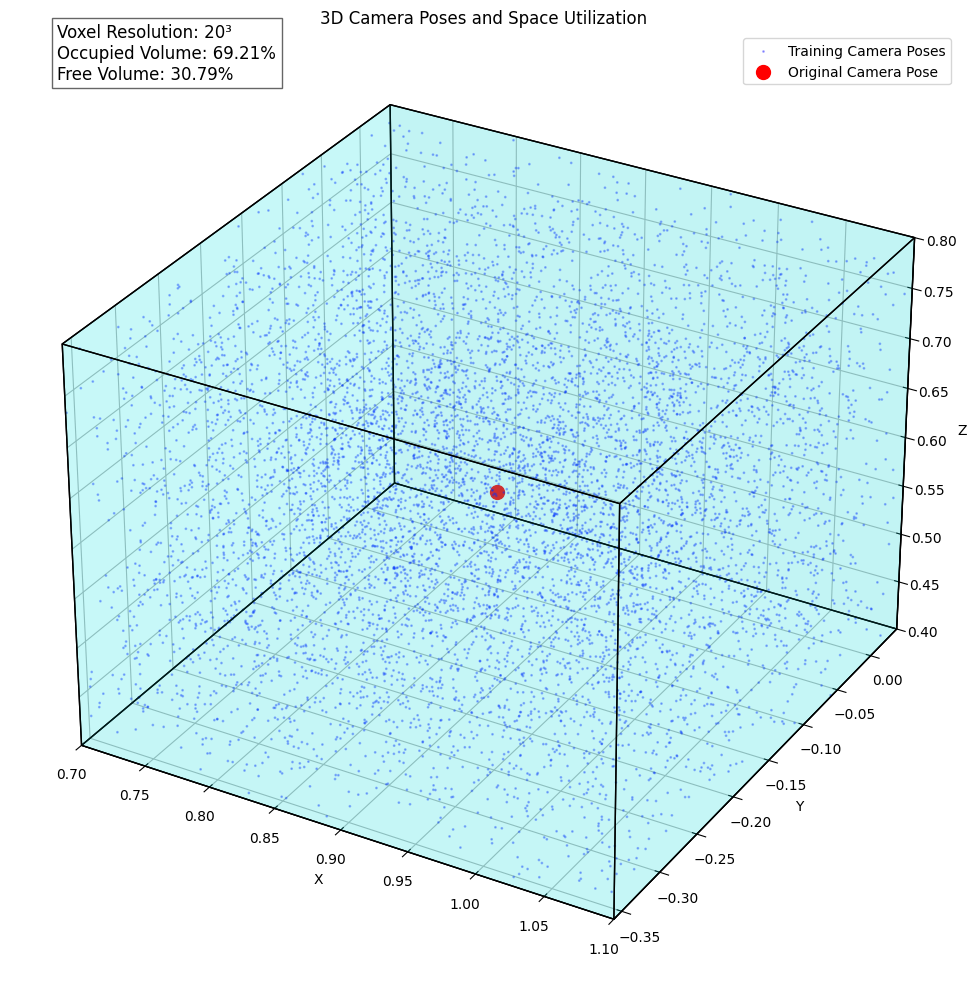

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Parameters
n_points = 8000
original_position = np.array([0.9, -0.16, 0.6])
camera_range = 0.2
voxel_resolution = 20  # more voxels = more accurate, but slower

# Cube bounds
cube_min = original_position - camera_range
cube_max = original_position + camera_range

# Generate random camera positions
camera_positions = np.random.uniform(low=cube_min, high=cube_max, size=(n_points, 3))

# Voxel grid
grid_x = np.linspace(cube_min[0], cube_max[0], voxel_resolution)
grid_y = np.linspace(cube_min[1], cube_max[1], voxel_resolution)
grid_z = np.linspace(cube_min[2], cube_max[2], voxel_resolution)

# Digitize each point into voxel indices
ix = np.digitize(camera_positions[:, 0], grid_x)
iy = np.digitize(camera_positions[:, 1], grid_y)
iz = np.digitize(camera_positions[:, 2], grid_z)

# Combine indices and count unique voxels
voxels = set(zip(ix, iy, iz))
occupied_voxels = len(voxels)
total_voxels = (voxel_resolution - 1) ** 3
occupied_ratio = occupied_voxels / total_voxels
free_ratio = 1 - occupied_ratio

# Define cube vertices
cube_vertices = np.array([
    [cube_min[0], cube_min[1], cube_min[2]],
    [cube_max[0], cube_min[1], cube_min[2]],
    [cube_max[0], cube_max[1], cube_min[2]],
    [cube_min[0], cube_max[1], cube_min[2]],
    [cube_min[0], cube_min[1], cube_max[2]],
    [cube_max[0], cube_min[1], cube_max[2]],
    [cube_max[0], cube_max[1], cube_max[2]],
    [cube_min[0], cube_max[1], cube_max[2]],
])
faces = [
    [cube_vertices[i] for i in [0, 1, 2, 3]],
    [cube_vertices[i] for i in [4, 5, 6, 7]],
    [cube_vertices[i] for i in [0, 1, 5, 4]],
    [cube_vertices[i] for i in [2, 3, 7, 6]],
    [cube_vertices[i] for i in [1, 2, 6, 5]],
    [cube_vertices[i] for i in [4, 7, 3, 0]],
]

# Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter points
ax.scatter(camera_positions[:, 0], camera_positions[:, 1], camera_positions[:, 2],
           color='blue', s=1, alpha=0.3, label='Training Camera Poses')

# Original position
ax.scatter(*original_position, color='red', s=100, label='Original Camera Pose')

# Cube
cube_poly = Poly3DCollection(faces, edgecolors='black', facecolors='cyan', linewidths=1, alpha=0.1)
ax.add_collection3d(cube_poly)

# Limits and labels
ax.set_xlim(cube_min[0], cube_max[0])
ax.set_ylim(cube_min[1], cube_max[1])
ax.set_zlim(cube_min[2], cube_max[2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Camera Poses and Space Utilization")

# Annotate space usage
annotation = (
    f"Voxel Resolution: {voxel_resolution}³\n"
    f"Occupied Volume: {occupied_ratio:.2%}\n"
    f"Free Volume: {free_ratio:.2%}"
)
ax.text2D(0.05, 0.95, annotation, transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

ax.legend()
plt.tight_layout()
plt.show()

In [2]:
%matplotlib inline

import json, os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import itertools

# 1) Robust loader for newline‐delimited JSON --------------------------------
def load_jsonl(path):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No file at {path!r}")
    data = []
    with open(path, 'r') as f:
        for i, line in enumerate(f, start=1):
            line = line.strip()
            if not line: 
                continue
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                raise ValueError(f"Bad JSON on line {i}: {e}")
    if not data:
        raise ValueError(f"No JSON objects found in {path!r}")
    return data

# 2) Load & extract camera poses --------------------------------------------
stats_path = 'isaac_ws/src/stats/fascia_y_1.json'   # ← adjust as needed
records = load_jsonl(stats_path)[1:]
cam_pts = np.array([r['initial_camera_pose'] for r in records])

# 3) Cube‐drawing helper ----------------------------------------------------
def draw_cube(ax, mn, mx, color, alpha=0.1):
    corners = np.array(list(itertools.product(
        [mn[0], mx[0]], [mn[1], mx[1]], [mn[2], mx[2]]
    )))
    faces = [
        [corners[i] for i in face] for face in
        ([0,1,3,2],[4,5,7,6],[0,1,5,4],
         [2,3,7,6],[1,3,7,5],[0,2,6,4])
    ]
    poly = Poly3DCollection(faces, facecolors=color, edgecolors=color, alpha=alpha)
    ax.add_collection3d(poly)

# 4) Define your “big” and “slice” cubes ------------------------------------
orig = np.array([0.9, -0.16, 0.6])
R = 0.2

big_min = orig - R
big_max = orig + R

sec_min = orig + np.array([-R,  0.2, -R])
sec_max = orig + np.array([ R,  0.3,  R])

# 5) Plot -------------------------------------------------------------------
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))

draw_cube(ax, big_min, big_max, color='blue', alpha=0.05)
draw_cube(ax, sec_min, sec_max, color='red',  alpha=0.10)

ax.scatter(cam_pts[:,0], cam_pts[:,1], cam_pts[:,2],
           c='black', s=4, depthshade=True, label='samples')
ax.scatter(*orig, c='green', s=50, marker='*', label='orig')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.legend(); plt.title('Camera spawn region (blue), slice (red), samples')
plt.show()

FileNotFoundError: No file at 'isaac_ws/src/stats/fascia_y_1.json'

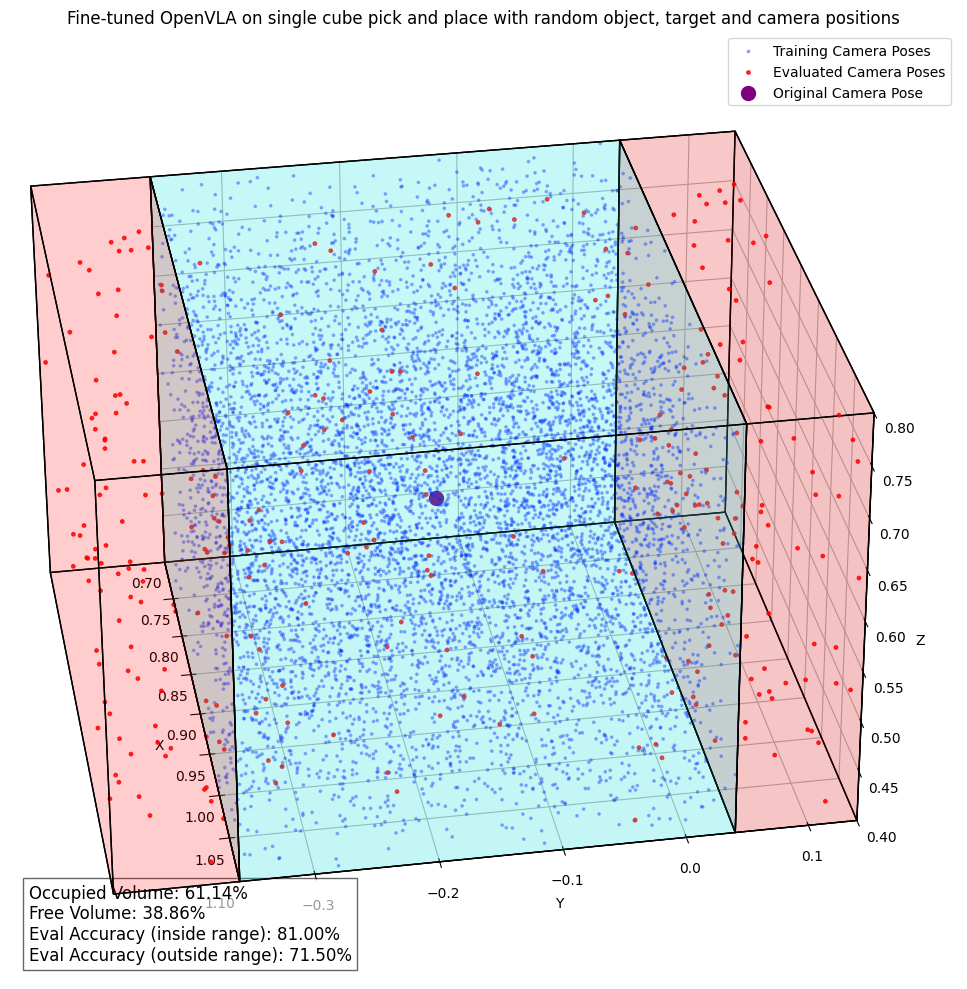

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import json

# === Load evaluated camera poses (skip first line) ===
def load_jsonl(filepath):
    with open(filepath, 'r') as f:
        return [json.loads(line) for line in f]

def get_flat_pose(pose):
    if isinstance(pose, list):
        if len(pose) == 1 and isinstance(pose[0], list):
            return pose[0]
        return pose
    raise ValueError(f"Unexpected pose format: {pose}")

# Adjust file path
stats_path1 = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_camerainrange.json'
records1 = load_jsonl(stats_path1)[1:]
evaluated_positions1 = np.array([get_flat_pose(r['initial_camera_pose']) for r in records1])

stats_path2 = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_rangeyout_-10.json'
records2 = load_jsonl(stats_path2)[1:]
evaluated_positions2 = np.array([get_flat_pose(r['initial_camera_pose']) for r in records2])

stats_path3 = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_rangeyout_+10.json'
records3 = load_jsonl(stats_path3)[1:]
evaluated_positions3 = np.array([get_flat_pose(r['initial_camera_pose']) for r in records3])

# === Combine evaluated positions and records ===
evaluated_positions = np.concatenate((evaluated_positions1, evaluated_positions2, evaluated_positions3), axis=0)
records = records1 + records2 + records3

# === Compute accuracies ===

# Inside cube
num_total1 = len(records1)
num_completed1 = sum(1 for r in records1 if r.get("completed") is True)
accuracy1 = num_completed1 / num_total1 if num_total1 > 0 else 0.0

# Outside cube
num_total2 = len(records2 + records3)
num_completed2 = sum(1 for r in records2 + records3 if r.get("completed") is True)
accuracy2 = num_completed2 / num_total2 if num_total2 > 0 else 0.0

# === Parameters ===
n_points = 7600
original_position = np.array([0.9, -0.16, 0.6])
camera_range = 0.2
voxel_resolution = 21

# === Cube bounds ===
cube_min = original_position - camera_range
cube_max = original_position + camera_range

# === Generate random training camera positions ===
camera_positions = np.random.uniform(low=cube_min, high=cube_max, size=(n_points, 3))

# === Voxelization ===
grid_x = np.linspace(cube_min[0], cube_max[0], voxel_resolution)
grid_y = np.linspace(cube_min[1], cube_max[1], voxel_resolution)
grid_z = np.linspace(cube_min[2], cube_max[2], voxel_resolution)

ix = np.digitize(camera_positions[:, 0], grid_x)
iy = np.digitize(camera_positions[:, 1], grid_y)
iz = np.digitize(camera_positions[:, 2], grid_z)

voxels = set(zip(ix, iy, iz))
occupied_voxels = len(voxels)
total_voxels = (voxel_resolution - 1) ** 3
occupied_ratio = occupied_voxels / total_voxels
free_ratio = 1 - occupied_ratio

# === Define main cube ===
cube_vertices = np.array([
    [cube_min[0], cube_min[1], cube_min[2]],
    [cube_max[0], cube_min[1], cube_min[2]],
    [cube_max[0], cube_max[1], cube_min[2]],
    [cube_min[0], cube_max[1], cube_min[2]],
    [cube_min[0], cube_min[1], cube_max[2]],
    [cube_max[0], cube_min[1], cube_max[2]],
    [cube_max[0], cube_max[1], cube_max[2]],
    [cube_min[0], cube_max[1], cube_max[2]],
])
faces = [
    [cube_vertices[i] for i in [0, 1, 2, 3]],
    [cube_vertices[i] for i in [4, 5, 6, 7]],
    [cube_vertices[i] for i in [0, 1, 5, 4]],
    [cube_vertices[i] for i in [2, 3, 7, 6]],
    [cube_vertices[i] for i in [1, 2, 6, 5]],
    [cube_vertices[i] for i in [4, 7, 3, 0]],
]

# === Define evaluated red cube ===
red_cube_min = cube_min.copy()
red_cube_max = cube_max.copy()
red_cube_min[1] = cube_max[1]
red_cube_max[1] = cube_max[1] + 0.1

red_vertices = np.array([
    [red_cube_min[0], red_cube_min[1], red_cube_min[2]],
    [red_cube_max[0], red_cube_min[1], red_cube_min[2]],
    [red_cube_max[0], red_cube_max[1], red_cube_min[2]],
    [red_cube_min[0], red_cube_max[1], red_cube_min[2]],
    [red_cube_min[0], red_cube_min[1], red_cube_max[2]],
    [red_cube_max[0], red_cube_min[1], red_cube_max[2]],
    [red_cube_max[0], red_cube_max[1], red_cube_max[2]],
    [red_cube_min[0], red_cube_max[1], red_cube_max[2]],
])
red_faces = [
    [red_vertices[i] for i in [0, 1, 2, 3]],
    [red_vertices[i] for i in [4, 5, 6, 7]],
    [red_vertices[i] for i in [0, 1, 5, 4]],
    [red_vertices[i] for i in [2, 3, 7, 6]],
    [red_vertices[i] for i in [1, 2, 6, 5]],
    [red_vertices[i] for i in [4, 7, 3, 0]],
]

# === Define second evaluated red cube (lower y region) ===
red_cube_min2 = cube_min.copy()
red_cube_max2 = cube_max.copy()
red_cube_max2[1] = cube_min[1]          # old min becomes upper bound
red_cube_min2[1] = cube_min[1] - 0.1    # extend downward by 0.1

red_vertices2 = np.array([
    [red_cube_min2[0], red_cube_min2[1], red_cube_min2[2]],
    [red_cube_max2[0], red_cube_min2[1], red_cube_min2[2]],
    [red_cube_max2[0], red_cube_max2[1], red_cube_min2[2]],
    [red_cube_min2[0], red_cube_max2[1], red_cube_min2[2]],
    [red_cube_min2[0], red_cube_min2[1], red_cube_max2[2]],
    [red_cube_max2[0], red_cube_min2[1], red_cube_max2[2]],
    [red_cube_max2[0], red_cube_max2[1], red_cube_max2[2]],
    [red_cube_min2[0], red_cube_max2[1], red_cube_max2[2]],
])
red_faces2 = [
    [red_vertices2[i] for i in [0, 1, 2, 3]],
    [red_vertices2[i] for i in [4, 5, 6, 7]],
    [red_vertices2[i] for i in [0, 1, 5, 4]],
    [red_vertices2[i] for i in [2, 3, 7, 6]],
    [red_vertices2[i] for i in [1, 2, 6, 5]],
    [red_vertices2[i] for i in [4, 7, 3, 0]],
]


# === Plotting ===
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Training poses
ax.scatter(camera_positions[:, 0], camera_positions[:, 1], camera_positions[:, 2],
           color='blue', s=3, alpha=0.3, label='Training Camera Poses')

# Evaluated poses
ax.scatter(evaluated_positions[:, 0], evaluated_positions[:, 1], evaluated_positions[:, 2],
           color='red', s=6, alpha=0.8, label='Evaluated Camera Poses')

# Original pose
ax.scatter(*original_position, color='purple', s=100, label='Original Camera Pose')

# Cubes
ax.add_collection3d(Poly3DCollection(faces, edgecolors='black', facecolors='cyan', linewidths=1, alpha=0.1))
ax.add_collection3d(Poly3DCollection(red_faces, edgecolors='black', facecolors='red', linewidths=1, alpha=0.1))
ax.add_collection3d(Poly3DCollection(red_faces2, edgecolors='black', facecolors='red', linewidths=1, alpha=0.1))

# Axes and labels
ax.set_xlim(cube_min[0], cube_max[0])
ax.set_ylim(cube_min[1], red_cube_max[1])  # extend y-limit
ax.set_zlim(cube_min[2], cube_max[2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Fine-tuned OpenVLA on single cube pick and place with random object, target and camera positions")

# Annotation
annotation = (
    #f"Voxel Resolution: {voxel_resolution}³\n"
    f"Occupied Volume: {occupied_ratio:.2%}\n"
    f"Free Volume: {free_ratio:.2%}\n"
    f"Eval Accuracy (inside range): {accuracy1:.2%}\n"
    f"Eval Accuracy (outside range): {accuracy2:.2%}"
)
ax.text2D(0.02, 0.02, annotation, transform=ax.transAxes, fontsize=12,
          bbox=dict(facecolor='white', alpha=0.6))
# get the current elevation & azimuth
current_elev = ax.elev
current_azim = ax.azim

# rotate horizontally by +90° but keep the same tilt
ax.view_init(elev=current_elev, azim=current_azim + 50)
ax.legend()
plt.tight_layout()
plt.show()

## This works! 

---

# Show histogram with 2 single models and their accuracy when evaluating

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import json

# === Load evaluated camera poses (skip first line) ===
def load_jsonl(filepath):
    with open(filepath, 'r') as f:
        return [json.loads(line) for line in f]

def get_flat_pose(pose):
    if isinstance(pose, list):
        if len(pose) == 1 and isinstance(pose[0], list):
            return pose[0]
        return pose
    raise ValueError(f"Unexpected pose format: {pose}")

# Adjust file path
stats_path1 = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_camerainrange.json'
records1 = load_jsonl(stats_path1)[1:]

stats_path2 = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_rangeyout_-10.json'
records2 = load_jsonl(stats_path2)[1:]

stats_path3 = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_rangeyout_+10.json'
records3 = load_jsonl(stats_path3)[1:]

stats_path4 = 'isaac_ws/src/stats/single_green_r_cub_r_tar_s_cam_100%/single_green_r_cub_r_tar_s_cam_incamerapose.json'
records4 = load_jsonl(stats_path4)[1:]

stats_path5 = 'isaac_ws/src/stats/single_green_r_cub_r_tar_s_cam_100%/single_green_r_cub_r_tar_s_cam_rangexyzcam_01.json'
records5 = load_jsonl(stats_path5)[1:]

# === Compute accuracies ===

# single_green_r_all_100%
# Inside cube
num_total1 = len(records1)
num_completed1 = sum(1 for r in records1 if r.get("completed") is True)
accuracy1 = num_completed1 / num_total1 if num_total1 > 0 else 0.0

# Outside cube
num_total2 = len(records2 + records3)
num_completed2 = sum(1 for r in records2 + records3 if r.get("completed") is True)
accuracy2 = num_completed2 / num_total2 if num_total2 > 0 else 0.0

# single_green_r_cub_r_tar_s_cam_100%
num_total3 = len(records4)
num_completed3 = sum(1 for r in records4 if r.get("completed") is True)
accuracy3 = num_completed3 / num_total3 if num_total3 > 0 else 0.0

# Outside cube
num_total4 = len(records5)
num_completed4 = sum(1 for r in records5 if r.get("completed") is True)
accuracy4 = num_completed4 / num_total4 if num_total4 > 0 else 0.0


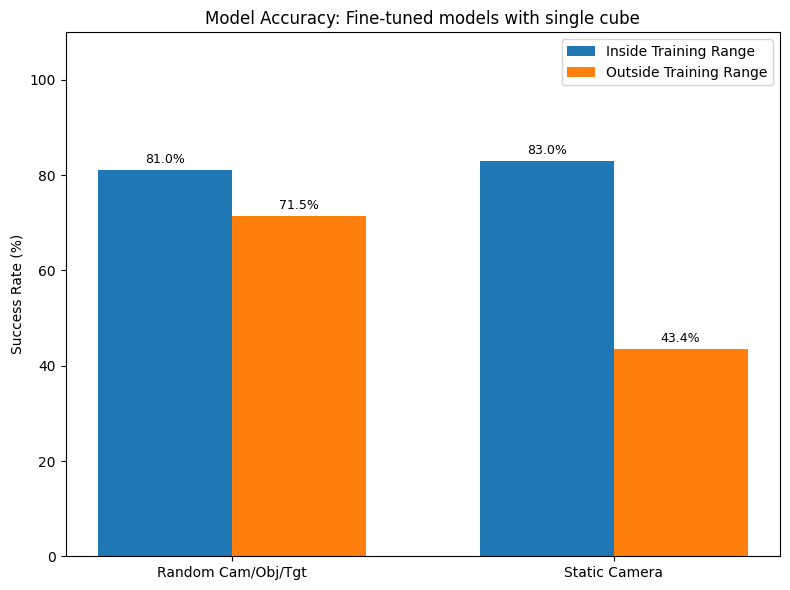

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# === Accuracy values ===
# Modello 1: single_green_r_all_100%
inside_all = accuracy1 * 100
outside_all = accuracy2 * 100

# Modello 2: single_green_r_cub_r_tar_s_cam_100%
inside_static = accuracy3 * 100
outside_static = accuracy4 * 100

# === Labels ===
models = ["Random Cam/Obj/Tgt", "Static Camera"]
x = np.arange(len(models))  # [0, 1]
width = 0.35

# === Bar chart ===
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, [inside_all, inside_static], width, label='Inside Training Range')
bars2 = ax.bar(x + width/2, [outside_all, outside_static], width, label='Outside Training Range')

# === Labels & Styling ===
ax.set_ylabel('Success Rate (%)')
ax.set_title('Model Accuracy: Fine-tuned models with single cube')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 110)
ax.legend()

# Annotate values on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


---

# Do the same for multicube


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import json

# === Load evaluated camera poses (skip first line) ===
def load_jsonl(filepath):
    with open(filepath, 'r') as f:
        return [json.loads(line) for line in f]

def get_flat_pose(pose):
    if isinstance(pose, list):
        if len(pose) == 1 and isinstance(pose[0], list):
            return pose[0]
        return pose
    raise ValueError(f"Unexpected pose format: {pose}")

# Adjust file path

## ^ === multi_s_cub_r_tar_r_cam_100% ===
stats_path1 = 'isaac_ws/src/stats/multi_s_cub_r_tar_r_cam_100%/multi_s_cub_r_tar_r_cam_camerainrange.json'
records1 = load_jsonl(stats_path1)[1:]

stats_path2 = 'isaac_ws/src/stats/multi_s_cub_r_tar_r_cam_100%/multi_s_cub_r_tar_r_cam_rangeyout_-10.json'
records2 = load_jsonl(stats_path2)[1:]

stats_path3 = 'isaac_ws/src/stats/multi_s_cub_r_tar_r_cam_100%/multi_s_cub_r_tar_r_cam_rangeyout_+10.json'
records3 = load_jsonl(stats_path3)[1:]

stats_path4 = 'isaac_ws/src/stats/multi_s_cub_r_tar_r_cam_100%/multi_s_cub_r_tar_r_cam_rangeyout_+20.json'
records4 = load_jsonl(stats_path4)[1:]

## ^ === multi_s_cub_r_tar_s_cam_100% ===
stats_path5 = 'isaac_ws/src/stats/multi_s_cub_r_tar_s_cam_100%/multi_s_cub_r_tar_s_cam_incamerapose.json'
records5 = load_jsonl(stats_path5)[1:]

stats_path6 = 'isaac_ws/src/stats/multi_s_cub_r_tar_s_cam_100%/multi_s_cub_r_tar_s_cam_rangexyzcam_-0.1_0.1.json'
records6 = load_jsonl(stats_path6)[1:]


# === Compute accuracies ===

# ^ multi_s_cub_r_tar_r_cam_100% 
# Inside cube
num_total1 = len(records1)
num_completed1 = sum(1 for r in records1 if r.get("completed") is True)
accuracy1 = num_completed1 / num_total1 if num_total1 > 0 else 0.0

# Outside cube
num_total2 = len(records2 + records3)
num_completed2 = sum(1 for r in records2 + records3 if r.get("completed") is True)
accuracy2 = num_completed2 / num_total2 if num_total2 > 0 else 0.0

num_total3 = len(records4)
num_completed3 = sum(1 for r in records4 if r.get("completed") is True)
accuracy3 = num_completed3 / num_total3 if num_total3 > 0 else 0.0

# ^ multi_s_cub_r_tar_s_cam_100%
# Inside range
num_total4 = len(records5)
num_completed4 = sum(1 for r in records5 if r.get("completed") is True)
accuracy4 = num_completed4 / num_total4 if num_total4 > 0 else 0.0

# Outside range
num_total5 = len(records6)
num_completed5 = sum(1 for r in records6 if r.get("completed") is True)
accuracy5 = num_completed5 / num_total5 if num_total5 > 0 else 0.0


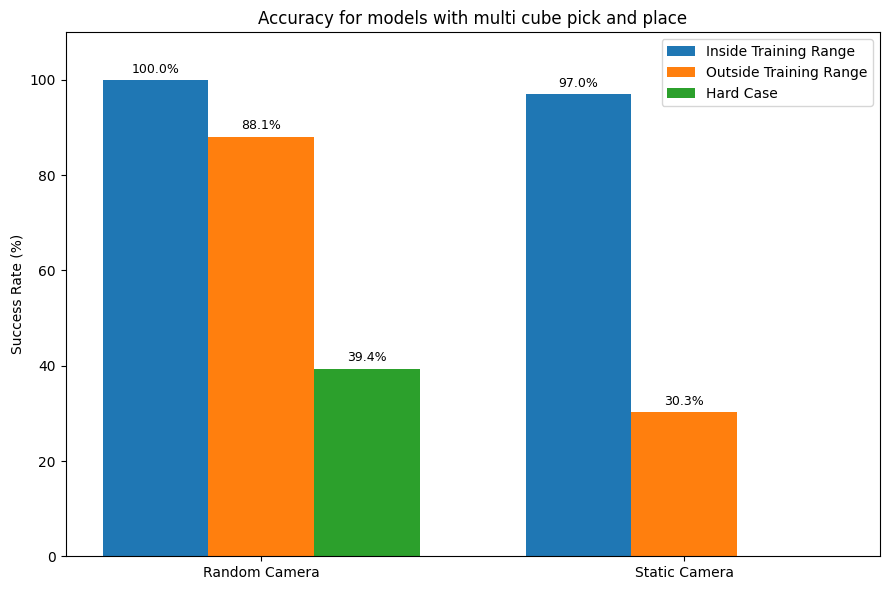

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# === Accuracy values (convert to %) ===
model_names = ['Random Camera', 'Static Camera']

inside = [accuracy1 * 100, accuracy4 * 100]
outside = [accuracy2 * 100, accuracy5 * 100]
hard    = [accuracy3 * 100, 0]  # second model has no hard case

# === Positions ===
x = np.arange(len(model_names))  # [0, 1]
width = 0.25

# === Plot ===
fig, ax = plt.subplots(figsize=(9, 6))
bars1 = ax.bar(x - width, inside, width, label='Inside Training Range')
bars2 = ax.bar(x, outside, width, label='Outside Training Range')
bars3 = ax.bar(x + width, hard, width, label='Hard Case')

# === Labels ===
ax.set_ylabel('Success Rate (%)')
ax.set_title('Accuracy for models with multi cube pick and place')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 110)
ax.legend()

# === Annotate bars ===
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


----

# Observe the average distance from the goal for trajectories which end up completed

In [10]:
def load_jsonl(filepath):
    with open(filepath, 'r') as f:
        return [json.loads(line) for line in f]

# Adjust file path
stats_path1 = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_camerainrange.json'
records1 = load_jsonl(stats_path1)[1:]
distance_to_goal1 = np.array([r['distance_object_target'] for r in records1 if r["completed"] == True])

print(distance_to_goal1.shape)

stats_path2 = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_rangeyout_-10.json'
records2 = load_jsonl(stats_path2)[1:]
distance_to_goal2 = np.array([r['distance_object_target'] for r in records2 if r["completed"] == True])

print(distance_to_goal2.shape)

stats_path3 = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_rangeyout_+10.json'
records3 = load_jsonl(stats_path3)[1:]
distance_to_goal3 = np.array([r['distance_object_target'] for r in records3 if r["completed"] == True])

print(distance_to_goal3.shape)

# Compute averages
avg_distance1 = np.mean(distance_to_goal1)
avg_distance2 = np.mean(distance_to_goal2)
avg_distance3 = np.mean(distance_to_goal3)

# Print results
print(f"Average distance to goal (inside range): {avg_distance1:.2f}")
print(f"Average distance to goal (outside range -10): {avg_distance2:.2f}")
print(f"Average distance to goal (outside range +10): {avg_distance3:.2f}")

(81,)
(80,)
(63,)
Average distance to goal (inside range): 0.03
Average distance to goal (outside range -10): 0.03
Average distance to goal (outside range +10): 0.03


## Now try to compute the same but for the other single model

In [11]:
def load_jsonl(filepath):
    with open(filepath, 'r') as f:
        return [json.loads(line) for line in f]

# Adjust file path
stats_path1 = 'isaac_ws/src/stats/single_green_r_cub_r_tar_s_cam_100%/single_green_r_cub_r_tar_s_cam_incamerapose.json'
records1 = load_jsonl(stats_path1)[1:]
distance_to_goal1 = np.array([r['distance_object_target'] for r in records1 if r["completed"] == True])

print(distance_to_goal1.shape)

stats_path2 = 'isaac_ws/src/stats/single_green_r_cub_r_tar_s_cam_100%/single_green_r_cub_r_tar_s_cam_rangexyzcam_01.json'
records2 = load_jsonl(stats_path2)[1:]
distance_to_goal2 = np.array([r['distance_object_target'] for r in records2 if r["completed"] == True])

print(distance_to_goal2.shape)

# Compute averages
avg_distance1 = np.mean(distance_to_goal1)
avg_distance2 = np.mean(distance_to_goal2)

# Print results
print(f"Average distance to goal (inside range): {avg_distance1:.2f}")
print(f"Average distance to goal (outside range): {avg_distance2:.2f}")

(83,)
(43,)
Average distance to goal (inside range): 0.03
Average distance to goal (outside range): 0.03


---

# Cubes with accuracy (depending on the camera position) of the four models with 100% dataset

## single_green_r_cub_r_tar_s_cam_100%

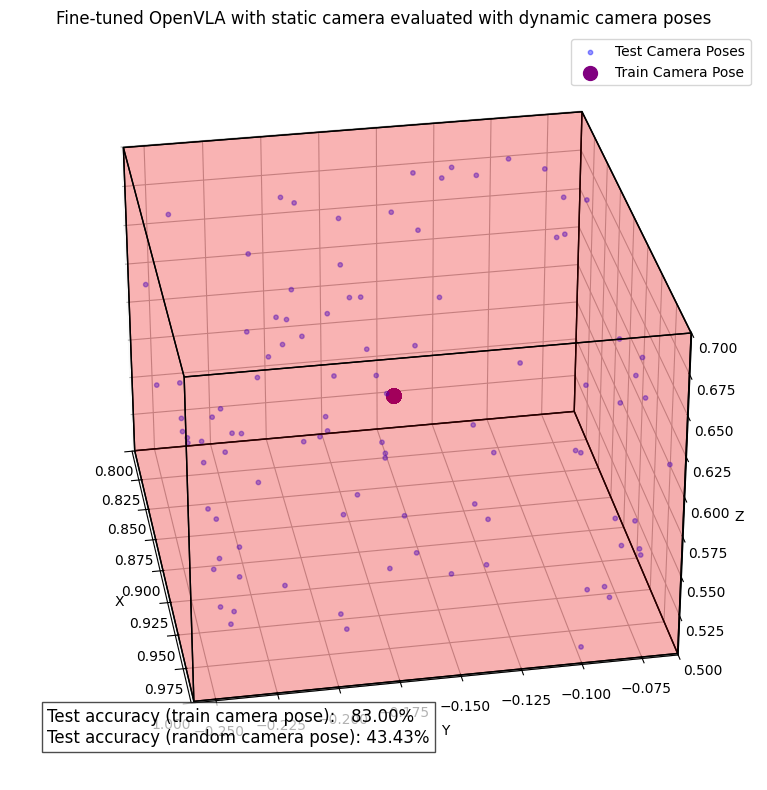

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import json

# === Helpers ===
def load_jsonl(filepath):
    with open(filepath, 'r') as f:
        records = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                records.append(json.loads(line))
            except json.JSONDecodeError:
                continue
        return records

def get_flat_pose(pose):
    if isinstance(pose, list):
        if len(pose) == 1 and isinstance(pose[0], list):
            return pose[0]
        return pose
    raise ValueError(f"Unexpected pose format: {pose}")

def cube_faces(cmin, cmax):
    # returns list of 6 faces, each a list of 4 corner points
    verts = np.array([
        [cmin[0], cmin[1], cmin[2]],
        [cmax[0], cmin[1], cmin[2]],
        [cmax[0], cmax[1], cmin[2]],
        [cmin[0], cmax[1], cmin[2]],
        [cmin[0], cmin[1], cmax[2]],
        [cmax[0], cmin[1], cmax[2]],
        [cmax[0], cmax[1], cmax[2]],
        [cmin[0], cmax[1], cmax[2]],
    ])
    idx = [(0,1,2,3), (4,5,6,7), (0,1,5,4),
           (2,3,7,6), (1,2,6,5), (4,7,3,0)]
    return [[verts[i] for i in face] for face in idx]

# === Load data ===
stats1 = 'isaac_ws/src/stats/single_green_r_cub_r_tar_s_cam_100%/single_green_r_cub_r_tar_s_cam_incamerapose.json'
stats2 = 'isaac_ws/src/stats/single_green_r_cub_r_tar_s_cam_100%/single_green_r_cub_r_tar_s_cam_rangexyzcam_01.json'

recs1 = load_jsonl(stats1)[1:]
recs2 = load_jsonl(stats2)[1:]

poses1 = np.array([get_flat_pose(r['initial_camera_pose']) for r in recs1])
poses2 = np.array([get_flat_pose(r['initial_camera_pose']) for r in recs2])

# === Compute accuracies ===
acc1 = sum(r.get("completed", False) for r in recs1) / max(len(recs1),1)
acc2 = sum(r.get("completed", False) for r in recs2) / max(len(recs2),1)

# === Define cubes ===
original_position = np.array([0.9, -0.16, 0.6])
cube_size = 0.2
half = cube_size / 2

# fixed cube centered on original_position
cube_min = original_position - half
cube_max = original_position + half
faces_training = cube_faces(cube_min, cube_max)

# bounding box around dynamic poses (poses2)
dyn_min = poses2.min(axis=0)
dyn_max = poses2.max(axis=0)
faces_dynamic = cube_faces(dyn_min, dyn_max)

# === Plot ===
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# dynamic camera poses
ax.scatter(poses2[:,0], poses2[:,1], poses2[:,2],
           color='blue', s=10, alpha=0.4, label='Test Camera Poses')

# static camera pose(s)
ax.scatter(poses1[:,0], poses1[:,1], poses1[:,2],
           color='purple', s=100, label='Train Camera Pose')

# training-region cube
# ax.add_collection3d(Poly3DCollection(faces_training,
#     facecolors='red', edgecolors='black', linewidths=1, alpha=0.15))

# dynamic-region bounding cube
ax.add_collection3d(Poly3DCollection(faces_dynamic,
    facecolors='red', edgecolors='black', linewidths=1, alpha=0.15))

# axes
# set limits to cover both cubes
all_min = np.minimum(cube_min, dyn_min)
all_max = np.maximum(cube_max, dyn_max)
ax.set_xlim(all_min[0], all_max[0])
ax.set_ylim(all_min[1], all_max[1])
ax.set_zlim(all_min[2], all_max[2])

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Fine-tuned OpenVLA with static camera evaluated with dynamic camera poses")

# annotation
txt = (
    f"Test accuracy (train camera pose):   {acc1:.2%}\n"
    f"Test accuracy (random camera pose): {acc2:.2%}"
)
ax.text2D(0.05, 0.05, txt, transform=ax.transAxes,
          bbox=dict(facecolor='white', alpha=0.7), fontsize=12)

# get the current elevation & azimuth
current_elev = ax.elev
current_azim = ax.azim
# rotate horizontally by +90° but keep the same tilt
ax.view_init(elev=current_elev, azim=current_azim + 50)
ax.legend()
plt.tight_layout()
plt.show()


## multi_s_cub_r_tar_r_cam_100%

In [13]:
def set_axes_equal(ax):
    """Make 3D axes have equal scale so spheres look like spheres,
       cubes like cubes."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    max_range = max(x_range, y_range, z_range)
    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)
    half = max_range / 2
    ax.set_xlim3d(x_middle - half, x_middle + half)
    ax.set_ylim3d(y_middle - half, y_middle + half)
    ax.set_zlim3d(z_middle - half, z_middle + half)


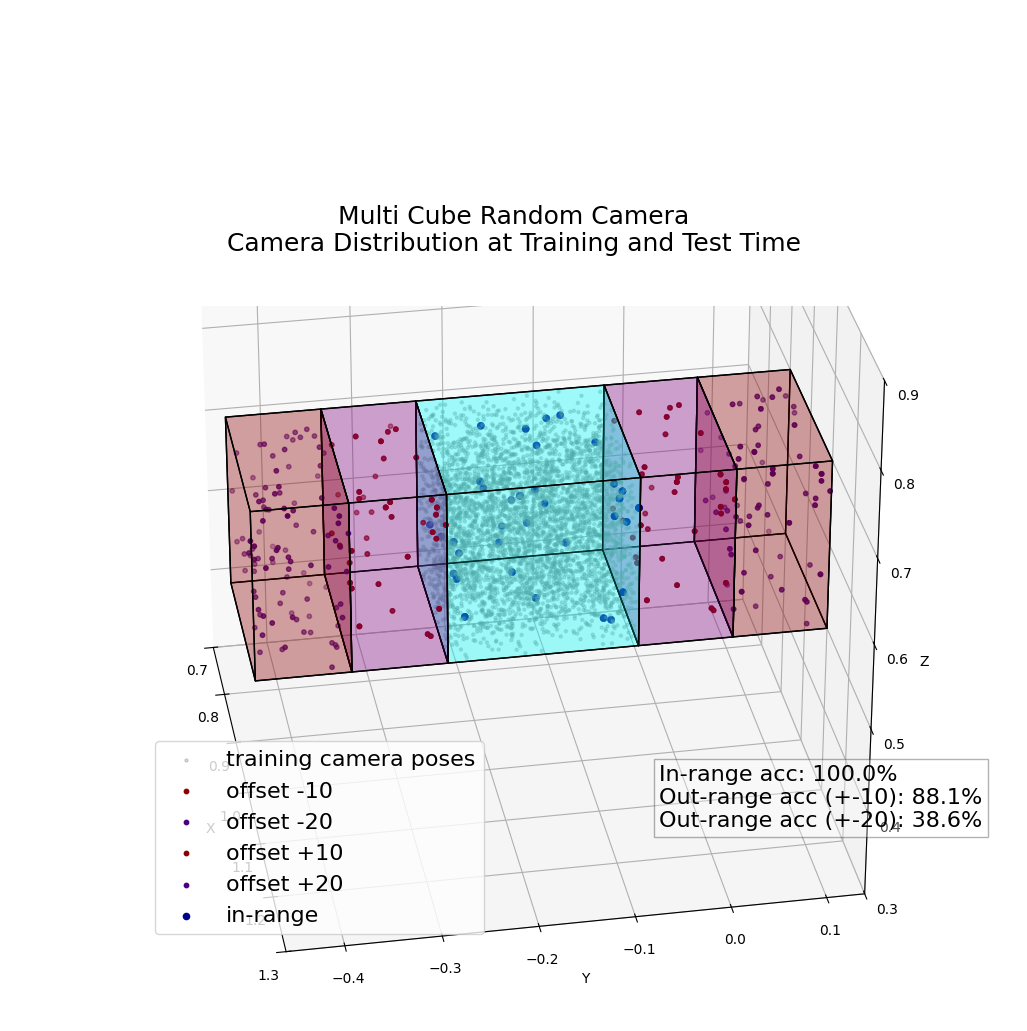

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import json

np.random.seed(42)

# === Helpers ===
def load_jsonl(path):
    recs = []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                recs.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return recs

def get_flat_pose(p):
    if isinstance(p, list):
        if len(p) == 1 and isinstance(p[0], list):
            return p[0]
        return p
    raise ValueError(f"Bad pose: {p}")

def cube_faces(cmin, cmax):
    v = np.array([
        [cmin[0], cmin[1], cmin[2]],
        [cmax[0], cmin[1], cmin[2]],
        [cmax[0], cmax[1], cmin[2]],
        [cmin[0], cmax[1], cmin[2]],
        [cmin[0], cmin[1], cmax[2]],
        [cmax[0], cmin[1], cmax[2]],
        [cmax[0], cmax[1], cmax[2]],
        [cmin[0], cmax[1], cmax[2]],
    ])
    idx = [(0,1,2,3), (4,5,6,7), (0,1,5,4),
           (2,3,7,6), (1,2,6,5), (4,7,3,0)]
    return [[v[i] for i in face] for face in idx]

# === Paths & loading ===
base_dir = 'isaac_ws/src/stats/multi_s_cub_r_tar_r_cam_100%'
files = {
    'in': '/multi_s_cub_r_tar_r_cam_camerainrange.json',
    '-10': '/multi_s_cub_r_tar_r_cam_rangeyout_-10.json',
    '-20': '/multi_s_cub_r_tar_r_cam_rangeyout_-20.json',
    '+10': '/multi_s_cub_r_tar_r_cam_rangeyout_+10.json',
    '+20': '/multi_s_cub_r_tar_r_cam_rangeyout_+20.json',
}

records = {}
poses = {}
for key, fn in files.items():
    rec = load_jsonl(base_dir + fn)[1:]
    records[key] = rec
    poses[key] = np.array([get_flat_pose(r['initial_camera_pose']) for r in rec])

# === Accuracies ===
acc_in = sum(r.get("completed", False) for r in records['in']) / max(1, len(records['in']))
all_out_10 = records['-10'] + records['+10']
all_out_20 = records['-20'] + records['+20']
acc_out_10 = sum(r.get("completed", False) for r in all_out_10) / max(1, len(all_out_10))
acc_out_20 = sum(r.get("completed", False) for r in all_out_20) / max(1, len(all_out_20))

# === Cube Setup ===
orig = np.array([1.0, -0.16, 0.6])
cam_range = 0.1  # Half-side
train_min = orig - cam_range
train_max = orig + cam_range
faces_main = cube_faces(train_min, train_max)

# Fasce adiacenti
offsets = {
    '-10': (train_min[1] - 0.10, train_min[1]),        # subito sotto il cubo
    '-20': (train_min[1] - 0.20, train_min[1] - 0.10),  # sotto -10
    '+10': (train_max[1], train_max[1] + 0.10),         # subito sopra il cubo
    '+20': (train_max[1] + 0.10, train_max[1] + 0.20),  # sopra +10
}

faces_ext = {}
for key, (ymin, ymax) in offsets.items():
    mn = train_min.copy()
    mx = train_max.copy()
    mn[1] = ymin
    mx[1] = ymax
    faces_ext[key] = cube_faces(mn, mx)

# === Plot ===
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Main training cube
ax.add_collection3d(Poly3DCollection(faces_main,
    edgecolors='black', facecolors='cyan', linewidths=1, alpha=0.2))

# Random training points
rand_pts = np.random.uniform(low=train_min, high=train_max, size=(4350, 3))
ax.scatter(rand_pts[:,0], rand_pts[:,1], rand_pts[:,2],
           c='grey', s=5, alpha=0.3, label='training camera poses')

# Voxels (optional)
voxel_resolution = 20
grid_x = np.linspace(train_min[0], train_max[0], voxel_resolution)
grid_y = np.linspace(train_min[1], train_max[1], voxel_resolution)
grid_z = np.linspace(train_min[2], train_max[2], voxel_resolution)

ix = np.digitize(rand_pts[:,0], grid_x)
iy = np.digitize(rand_pts[:,1], grid_y)
iz = np.digitize(rand_pts[:,2], grid_z)

voxels = set(zip(ix, iy, iz))
occupied_voxels = len(voxels)
total_voxels = (voxel_resolution - 1) ** 3
occupied_ratio = occupied_voxels / total_voxels

# Colors
cube_colors = {
    '-10': 'purple',
    '+10': 'purple',
    '-20': 'darkred',
    '+20': 'darkred'
}
point_colors = {
    '-10': 'darkred',
    '+10': 'darkred',
    '-20': 'indigo',
    '+20': 'indigo'
}

# Extension cubes
for key, face_list in faces_ext.items():
    fc = cube_colors.get(key)
    pc = point_colors.get(key)
    ax.add_collection3d(Poly3DCollection(face_list,
        edgecolors='black', facecolors=fc, linewidths=1, alpha=0.2))
    pts = poses[key]
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=10, label=f'offset {key}', color=pc)

# In-range
in_pts = poses['in']
ax.scatter(in_pts[:,0], in_pts[:,1], in_pts[:,2],
           s=20, label='in-range', color='darkblue')

# Axis limits
ax.set_xlim(train_min[0], train_max[0])
ax.set_ylim(train_min[1] - 0.20, train_max[1] + 0.20)
ax.set_zlim(train_min[2], train_max[2])

def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    max_range = max(x_range, y_range, z_range)
    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)
    ax.set_xlim3d(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim3d(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim3d(mid_z - max_range/2, mid_z + max_range/2)



set_axes_equal(ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.text(
    0.5, 0.78,  # posizione del box nella figura
    '\n\n\n\n\n\n\n                                         Multi Cube Random Camera                                         \nCamera Distribution at Training and Test Time',
    ha='center',
    va='bottom',  # testo allineato alla parte bassa del box
    fontsize=18,
    bbox=dict(
        facecolor='white',
        alpha=1.0,
        edgecolor='none',
        boxstyle='square,pad=2'  # padding attorno al testo
    )
)

info = "In-range acc: 100.0%\nOut-range acc (+-10): 88.1%\nOut-range acc (+-20): 38.6%"
ax.text2D(0.65, 0.20, info, transform=ax.transAxes,
          bbox=dict(facecolor='white', alpha=0.3), fontsize=16)


ax.view_init(elev=ax.elev, azim=ax.azim + 50)
ax.legend(loc='upper center', bbox_to_anchor=(0.3, 0.30), fontsize=16)

ax.set_box_aspect((1, 1, 1))
plt.tight_layout()
plt.show()



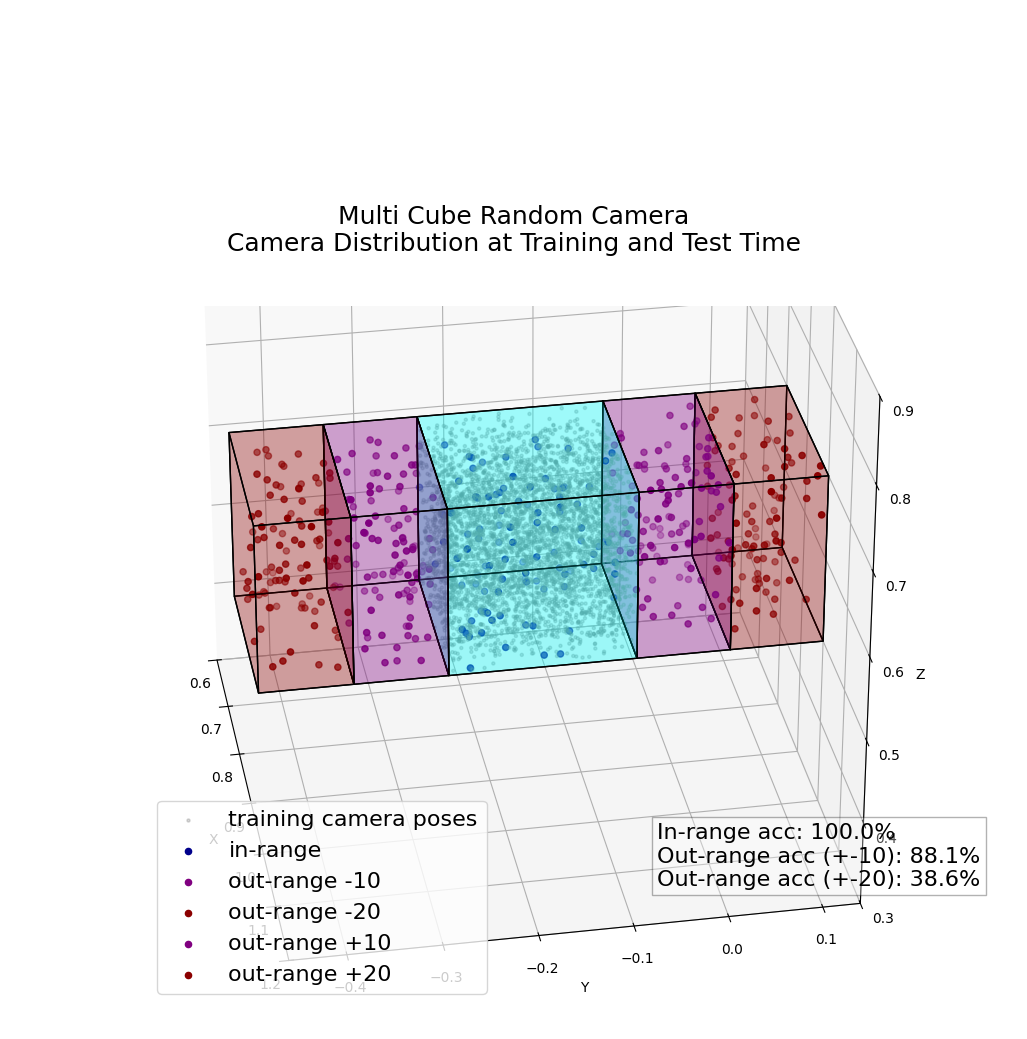

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import json

np.random.seed(30)

# === Helpers ===
def load_jsonl(path):
    recs = []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                recs.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return recs

def get_flat_pose(p):
    if isinstance(p, list):
        if len(p) == 1 and isinstance(p[0], list):
            return p[0]
        return p
    raise ValueError(f"Bad pose: {p}")

def cube_faces(cmin, cmax):
    v = np.array([
        [cmin[0], cmin[1], cmin[2]],
        [cmax[0], cmin[1], cmin[2]],
        [cmax[0], cmax[1], cmin[2]],
        [cmin[0], cmax[1], cmin[2]],
        [cmin[0], cmin[1], cmax[2]],
        [cmax[0], cmin[1], cmax[2]],
        [cmax[0], cmax[1], cmax[2]],
        [cmin[0], cmax[1], cmax[2]],
    ])
    idx = [(0,1,2,3), (4,5,6,7), (0,1,5,4),
           (2,3,7,6), (1,2,6,5), (4,7,3,0)]
    return [[v[i] for i in face] for face in idx]

# === Paths & loading ===
base_dir = 'isaac_ws/src/stats/multi_s_cub_r_tar_r_cam_100%'
files = {
    'in': '/multi_s_cub_r_tar_r_cam_camerainrange.json',
    '-10': '/multi_s_cub_r_tar_r_cam_rangeyout_-10.json',
    '-20': '/multi_s_cub_r_tar_r_cam_rangeyout_-20.json',
    '+10': '/multi_s_cub_r_tar_r_cam_rangeyout_+10.json',
    '+20': '/multi_s_cub_r_tar_r_cam_rangeyout_+20.json',
}

records = {}
poses = {}
for key, fn in files.items():
    rec = load_jsonl(base_dir + fn)[1:]
    records[key] = rec
    poses[key] = np.array([get_flat_pose(r['initial_camera_pose']) for r in rec])

# === Accuracies ===
acc_in = sum(r.get("completed", False) for r in records['in']) / max(1, len(records['in']))
all_out_10 = records['-10'] + records['+10']
all_out_20 = records['-20'] + records['+20']
acc_out_10 = sum(r.get("completed", False) for r in all_out_10) / max(1, len(all_out_10))
acc_out_20 = sum(r.get("completed", False) for r in all_out_20) / max(1, len(all_out_20))

# === Cube Setup ===
orig = np.array([0.9, -0.16, 0.6])
cam_range = 0.1  # Half-side
train_min = orig - cam_range
train_max = orig + cam_range
faces_main = cube_faces(train_min, train_max)

# Fasce adiacenti
offsets = {
    '-10': (train_min[1] - 0.10, train_min[1]),        # subito sotto il cubo
    '-20': (train_min[1] - 0.20, train_min[1] - 0.10),  # sotto -10
    '+10': (train_max[1], train_max[1] + 0.10),         # subito sopra il cubo
    '+20': (train_max[1] + 0.10, train_max[1] + 0.20),  # sopra +10
}

faces_ext = {}
for key, (ymin, ymax) in offsets.items():
    mn = train_min.copy()
    mx = train_max.copy()
    mn[1] = ymin
    mx[1] = ymax
    faces_ext[key] = cube_faces(mn, mx)

# === Plot ===
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Main training cube
ax.add_collection3d(Poly3DCollection(faces_main,
    edgecolors='black', facecolors='cyan', linewidths=1, alpha=0.2))

num_points = 100
# Random training points
rand_pts = np.random.uniform(low=train_min, high=train_max, size=(4350, 3))
rand_pts_cube = np.random.uniform(low=train_min, high=train_max, size=(num_points, 3))
rand_pts_cube_minus10 = np.column_stack((
    np.random.uniform(train_min[0], train_max[0], num_points),
    np.random.uniform(offsets['-10'][0], offsets['-10'][1], num_points),
    np.random.uniform(train_min[2], train_max[2], num_points)
))

rand_pts_cube_minus20 = np.column_stack((
    np.random.uniform(train_min[0], train_max[0], num_points),
    np.random.uniform(offsets['-20'][0], offsets['-20'][1], num_points),
    np.random.uniform(train_min[2], train_max[2], num_points)
))

rand_pts_cube_plus10 = np.column_stack((
    np.random.uniform(train_min[0], train_max[0], num_points),
    np.random.uniform(offsets['+10'][0], offsets['+10'][1], num_points),
    np.random.uniform(train_min[2], train_max[2], num_points)
))

rand_pts_cube_plus20 = np.column_stack((
    np.random.uniform(train_min[0], train_max[0], num_points),
    np.random.uniform(offsets['+20'][0], offsets['+20'][1], num_points),
    np.random.uniform(train_min[2], train_max[2], num_points)
))
ax.scatter(rand_pts[:,0], rand_pts[:,1], rand_pts[:,2],
           c='grey', s=5, alpha=0.3, label='training camera poses')

ax.scatter(rand_pts_cube[:,0], rand_pts_cube[:,1], rand_pts_cube[:,2],
              s=20, label='in-range', color='darkblue')
ax.scatter(rand_pts_cube_minus10[:,0], rand_pts_cube_minus10[:,1], rand_pts_cube_minus10[:,2],
              s=20, label='out-range -10', color='purple')
ax.scatter(rand_pts_cube_minus20[:,0], rand_pts_cube_minus20[:,1], rand_pts_cube_minus20[:,2],
                s=20, label='out-range -20', color='darkred')
ax.scatter(rand_pts_cube_plus10[:,0], rand_pts_cube_plus10[:,1], rand_pts_cube_plus10[:,2],
                s=20, label='out-range +10', color='purple')
ax.scatter(rand_pts_cube_plus20[:,0], rand_pts_cube_plus20[:,1], rand_pts_cube_plus20[:,2], 
                s=20, label='out-range +20', color='darkred')


# Voxels (optional)
voxel_resolution = 20
grid_x = np.linspace(train_min[0], train_max[0], voxel_resolution)
grid_y = np.linspace(train_min[1], train_max[1], voxel_resolution)
grid_z = np.linspace(train_min[2], train_max[2], voxel_resolution)

ix = np.digitize(rand_pts[:,0], grid_x)
iy = np.digitize(rand_pts[:,1], grid_y)
iz = np.digitize(rand_pts[:,2], grid_z)

voxels = set(zip(ix, iy, iz))
occupied_voxels = len(voxels)
total_voxels = (voxel_resolution - 1) ** 3
occupied_ratio = occupied_voxels / total_voxels

# Colors
cube_colors = {
    '-10': 'purple',
    '+10': 'purple',
    '-20': 'darkred',
    '+20': 'darkred'
}
point_colors = {
    '-10': 'darkred',
    '+10': 'darkred',
    '-20': 'indigo',
    '+20': 'indigo'
}

# Extension cubes
for key, face_list in faces_ext.items():
    fc = cube_colors.get(key)
    pc = point_colors.get(key)
    ax.add_collection3d(Poly3DCollection(face_list,
        edgecolors='black', facecolors=fc, linewidths=1, alpha=0.2))
    pts = poses[key]
    #ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=10, label=f'offset {key}', color=pc)

# In-range
in_pts = poses['in']
# ax.scatter(in_pts[:,0], in_pts[:,1], in_pts[:,2],
#            s=20, label='in-range', color='darkblue')

# Axis limits
ax.set_xlim(train_min[0], train_max[0])
ax.set_ylim(train_min[1] - 0.20, train_max[1] + 0.20)
ax.set_zlim(train_min[2], train_max[2])

def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    max_range = max(x_range, y_range, z_range)
    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)
    ax.set_xlim3d(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim3d(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim3d(mid_z - max_range/2, mid_z + max_range/2)



set_axes_equal(ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.text(
    0.5, 0.8,  # posizione del box nella figura
    '\n\n\n\n\n\n\n                                         Multi Cube Random Camera                                         \nCamera Distribution at Training and Test Time',
    ha='center',
    va='bottom',  # testo allineato alla parte bassa del box
    fontsize=18,
    bbox=dict(
        facecolor='white',
        alpha=1.0,
        edgecolor='none',
        boxstyle='square,pad=2'  # padding attorno al testo
    )
)
info = "In-range acc: 100.0%\nOut-range acc (+-10): 88.1%\nOut-range acc (+-20): 38.6%"

ax.text2D(0.65, 0.15, info, transform=ax.transAxes,
          bbox=dict(facecolor='white', alpha=0.3), fontsize=16)


ax.view_init(elev=ax.elev, azim=ax.azim + 50)
ax.legend(loc='upper center', bbox_to_anchor=(0.3, 0.25), fontsize=16)

ax.set_box_aspect((1, 1, 1))
plt.tight_layout()
plt.show()



## multi_s_cub_r_tar_s_cam_100%

min camera pose:  [ 0.9  -0.16  0.6 ] max camera pose:  [ 0.9  -0.16  0.6 ]
min camera pose:  [ 0.80502468 -0.25167641  0.5011825 ] max camera pose:  [ 0.99940562 -0.06015848  0.69979268]


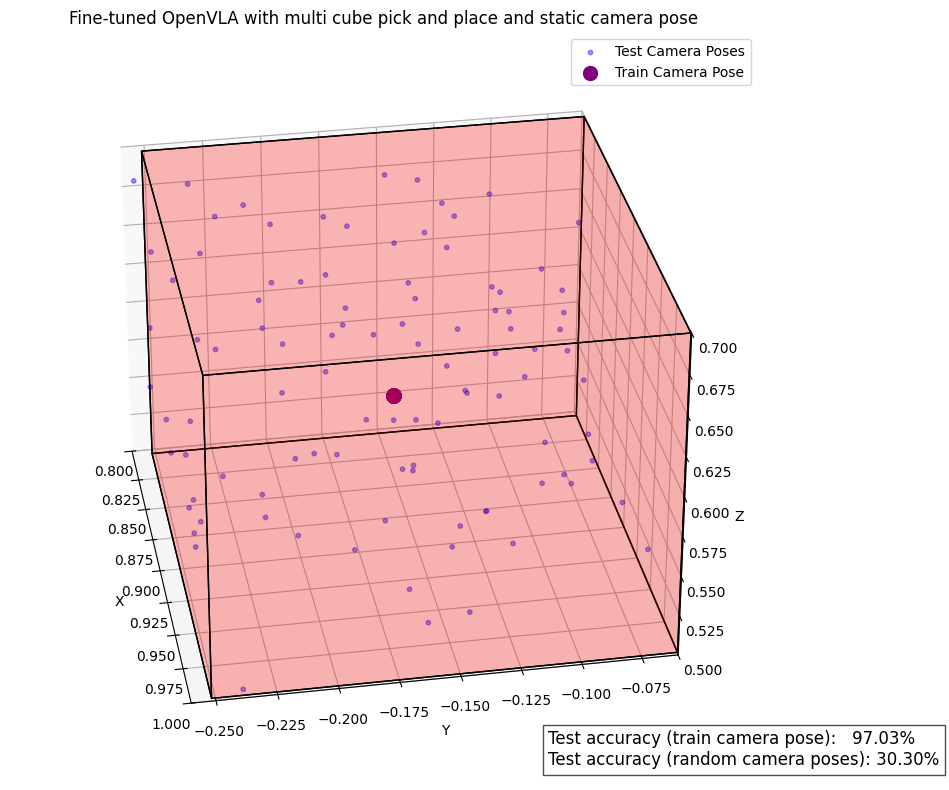

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import json

# === Helpers ===
def load_jsonl(filepath):
    with open(filepath, 'r') as f:
        records = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                records.append(json.loads(line))
            except json.JSONDecodeError:
                continue
        return records

def get_flat_pose(pose):
    if isinstance(pose, list):
        if len(pose) == 1 and isinstance(pose[0], list):
            return pose[0]
        return pose
    raise ValueError(f"Unexpected pose format: {pose}")

def cube_faces(cmin, cmax):
    # returns list of 6 faces, each a list of 4 corner points
    verts = np.array([
        [cmin[0], cmin[1], cmin[2]],
        [cmax[0], cmin[1], cmin[2]],
        [cmax[0], cmax[1], cmin[2]],
        [cmin[0], cmax[1], cmin[2]],
        [cmin[0], cmin[1], cmax[2]],
        [cmax[0], cmin[1], cmax[2]],
        [cmax[0], cmax[1], cmax[2]],
        [cmin[0], cmax[1], cmax[2]],
    ])
    idx = [(0,1,2,3), (4,5,6,7), (0,1,5,4),
           (2,3,7,6), (1,2,6,5), (4,7,3,0)]
    return [[verts[i] for i in face] for face in idx]

# === Load data ===
stats1 = 'isaac_ws/src/stats/multi_s_cub_r_tar_s_cam_100%/multi_s_cub_r_tar_s_cam_incamerapose.json'
stats2 = 'isaac_ws/src/stats/multi_s_cub_r_tar_s_cam_100%/multi_s_cub_r_tar_s_cam_rangexyzcam_-0.1_0.1.json'

recs1 = load_jsonl(stats1)[1:]
recs2 = load_jsonl(stats2)[1:]

poses1 = np.array([get_flat_pose(r['initial_camera_pose']) for r in recs1])
poses2 = np.array([get_flat_pose(r['initial_camera_pose']) for r in recs2])

# Sanity check on the positions
print("min camera pose: ", poses1.min(axis=0), "max camera pose: ", poses1.max(axis=0))
print("min camera pose: ", poses2.min(axis=0), "max camera pose: ", poses2.max(axis=0))

# === Compute accuracies ===
acc1 = sum(r.get("completed", False) for r in recs1) / max(len(recs1),1)
acc2 = sum(r.get("completed", False) for r in recs2) / max(len(recs2),1)

# === Define cubes ===
original_position = np.array([0.9, -0.16, 0.6])
cube_size = 0.2
half = cube_size / 2

# fixed cube centered on original_position
cube_min = original_position - half
cube_max = original_position + half
faces_training = cube_faces(cube_min, cube_max)

# bounding box around dynamic poses (poses2)
dyn_min = poses2.min(axis=0)
dyn_max = poses2.max(axis=0)
faces_dynamic = cube_faces(dyn_min, dyn_max)

# === Plot ===
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
# === Generate random poses within the fixed cube ===
num_poses = 100
poses = np.random.uniform(low=cube_min, high=cube_max, size=(num_poses, 3))

# # dynamic camera poses
# ax.scatter(poses2[:,0], poses2[:,1], poses2[:,2],
#            color='blue', s=10, alpha=0.4, label='Test Camera Poses')

# dynamic camera poses
ax.scatter(poses[:,0], poses[:,1], poses[:,2],
           color='blue', s=10, alpha=0.4, label='Test Camera Poses')


# static camera pose(s)
ax.scatter(poses1[:,0], poses1[:,1], poses1[:,2],
           color='purple', s=100, label='Train Camera Pose')

# training-region cube
# ax.add_collection3d(Poly3DCollection(faces_training,
#     facecolors='red', edgecolors='black', linewidths=1, alpha=0.15))

# dynamic-region bounding cube
ax.add_collection3d(Poly3DCollection(faces_dynamic,
    facecolors='red', edgecolors='black', linewidths=1, alpha=0.15))

# axes
# set limits to cover both cubes
all_min = np.minimum(cube_min, dyn_min)
all_max = np.maximum(cube_max, dyn_max)
ax.set_xlim(all_min[0], all_max[0])
ax.set_ylim(all_min[1], all_max[1])
ax.set_zlim(all_min[2], all_max[2])

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Fine-tuned OpenVLA with multi cube pick and place and static camera pose")

# annotation
txt = (
    f"Test accuracy (train camera pose):   {acc1:.2%}\n"
    f"Test accuracy (random camera poses): {acc2:.2%}"
)
ax.text2D(0.72, 0.02, txt, transform=ax.transAxes,
          bbox=dict(facecolor='white', alpha=0.7), fontsize=12)

# get the current elevation & azimuth
current_elev = ax.elev
current_azim = ax.azim
# rotate horizontally by +90° but keep the same tilt
ax.view_init(elev=current_elev, azim=current_azim + 50)
ax.legend()
plt.tight_layout()
plt.show()


----

# Histogram of the 4 models (100%) with two accuracies each

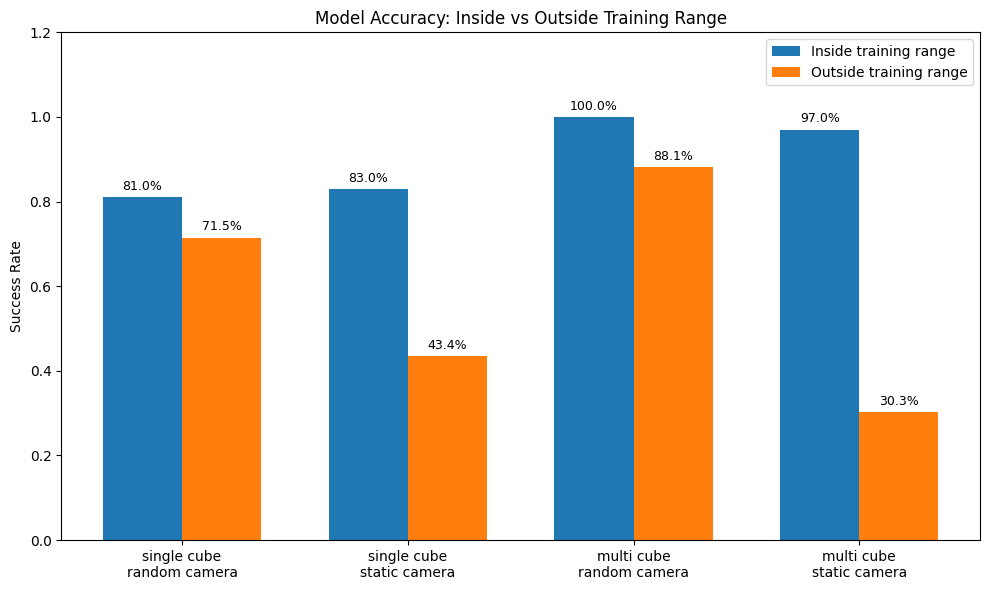

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import json

# === Helper to load JSONL, skipping the first line if needed ===
def load_jsonl(path, skip_first=True):
    recs = []
    with open(path, 'r') as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        if skip_first and i == 0:
            continue
        line = line.strip()
        if not line:
            continue
        try:
            recs.append(json.loads(line))
        except json.JSONDecodeError:
            continue
    return recs

# === Model A: single_green_r_all_100% ===
A_in_path    = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_camerainrange.json'
A_out1_path  = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_rangeyout_-10.json'
A_out2_path  = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_rangeyout_+10.json'

records_A_in  = load_jsonl(A_in_path,   skip_first=True)
records_A_out = load_jsonl(A_out1_path, skip_first=True) + \
                load_jsonl(A_out2_path, skip_first=True)

acc_A_in  = sum(r.get("completed", False) for r in records_A_in)  / max(1, len(records_A_in))
acc_A_out = sum(r.get("completed", False) for r in records_A_out) / max(1, len(records_A_out))

# === Model B: single_green_r_cub_r_tar_s_cam_100% ===
B_in_path   = 'isaac_ws/src/stats/single_green_r_cub_r_tar_s_cam_100%/single_green_r_cub_r_tar_s_cam_incamerapose.json'
B_out_path  = 'isaac_ws/src/stats/single_green_r_cub_r_tar_s_cam_100%/single_green_r_cub_r_tar_s_cam_rangexyzcam_01.json'

records_B_in  = load_jsonl(B_in_path,  skip_first=True)
records_B_out = load_jsonl(B_out_path, skip_first=True)

acc_B_in  = sum(r.get("completed", False) for r in records_B_in)  / max(1, len(records_B_in))
acc_B_out = sum(r.get("completed", False) for r in records_B_out) / max(1, len(records_B_out))

# === Model C: multi_s_cub_r_tar_r_cam_100% ===
C_base = 'isaac_ws/src/stats/multi_s_cub_r_tar_r_cam_100%'
C_paths = {
    'in':   '/multi_s_cub_r_tar_r_cam_camerainrange.json',
    '-10':  '/multi_s_cub_r_tar_r_cam_rangeyout_-10.json',
    '-20':  '/multi_s_cub_r_tar_r_cam_rangeyout_-20.json',
    '+10':  '/multi_s_cub_r_tar_r_cam_rangeyout_+10.json',
    '+20':  '/multi_s_cub_r_tar_r_cam_rangeyout_+20.json',
}

records_C = {k: load_jsonl(C_base + p, skip_first=True) for k, p in C_paths.items()}
records_C_in  = records_C['in']
records_C_out = (records_C['-10']  +
                 records_C['+10'])

acc_C_in  = sum(r.get("completed", False) for r in records_C_in)  / max(1, len(records_C_in))
acc_C_out = sum(r.get("completed", False) for r in records_C_out) / max(1, len(records_C_out))

# === Model D: multi_s_cub_r_tar_s_cam_100% ===
D_in_path  = 'isaac_ws/src/stats/multi_s_cub_r_tar_s_cam_100%/multi_s_cub_r_tar_s_cam_incamerapose.json'
D_out_path = 'isaac_ws/src/stats/multi_s_cub_r_tar_s_cam_100%/multi_s_cub_r_tar_s_cam_rangexyzcam_-0.1_0.1.json'

records_D_in  = load_jsonl(D_in_path,  skip_first=True)
records_D_out = load_jsonl(D_out_path, skip_first=True)

acc_D_in  = sum(r.get("completed", False) for r in records_D_in)  / max(1, len(records_D_in))
acc_D_out = sum(r.get("completed", False) for r in records_D_out) / max(1, len(records_D_out))

# === Prepare data for plotting ===
model_labels = [
    "single cube\nrandom camera",
    "single cube\nstatic camera",
    "multi cube\nrandom camera",
    "multi cube\nstatic camera"
]
inside_acc  = [acc_A_in, acc_B_in, acc_C_in, acc_D_in]
outside_acc = [acc_A_out, acc_B_out, acc_C_out, acc_D_out]

x = np.arange(len(model_labels))
width = 0.35

# === Plot grouped bar chart ===
fig, ax = plt.subplots(figsize=(10, 6))
bars_in  = ax.bar(x - width/2, inside_acc,  width, label='Inside training range')
bars_out = ax.bar(x + width/2, outside_acc, width, label='Outside training range')

ax.set_ylabel("Success Rate")
ax.set_title("Model Accuracy: Inside vs Outside Training Range")
ax.set_xticks(x)
ax.set_xticklabels(model_labels)
ax.set_ylim(0, 1.2)
ax.legend()

# Annotate percentages on each bar
for bar in bars_in + bars_out:
    h = bar.get_height()
    ax.annotate(f"{h:.1%}",
                xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 3), textcoords="offset points",
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


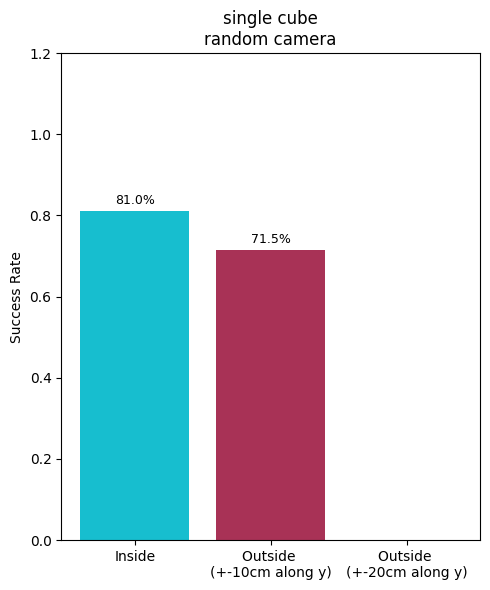

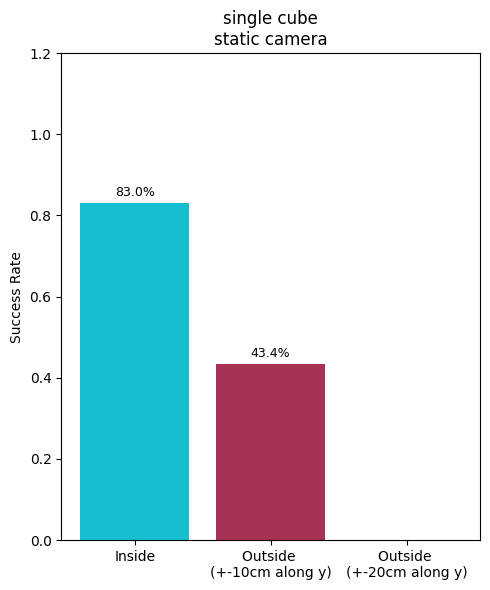

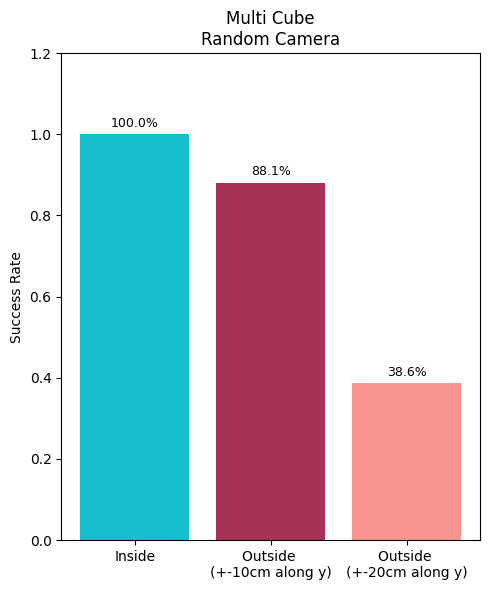

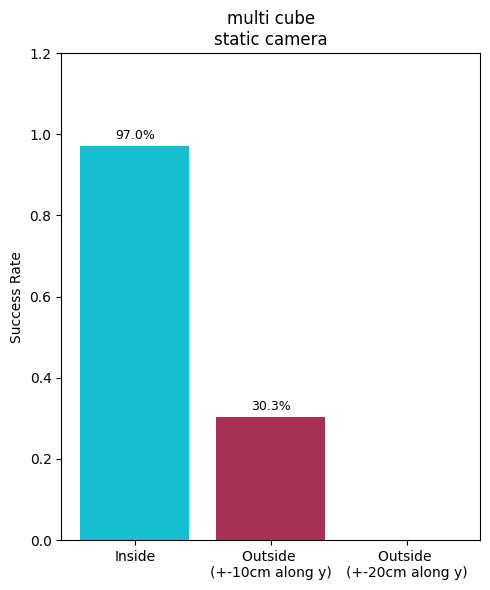

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json

# === Helper to load JSONL ===
def load_jsonl(path, skip_first=True):
    recs = []
    with open(path, 'r') as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        if skip_first and i == 0:
            continue
        line = line.strip()
        if not line:
            continue
        try:
            recs.append(json.loads(line))
        except json.JSONDecodeError:
            continue
    return recs

# === Model A === (single cube, random cam)
A_in_path    = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_camerainrange.json'
A_out1_path  = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_rangeyout_-10.json'
A_out2_path  = 'isaac_ws/src/stats/single_green_r_all_100%/single_green_r_all_rangeyout_+10.json'

records_A_in  = load_jsonl(A_in_path)
records_A_out = load_jsonl(A_out1_path) + load_jsonl(A_out2_path)

acc_A_in   = sum(r.get("completed", False) for r in records_A_in)  / max(1, len(records_A_in))
acc_A_near = sum(r.get("completed", False) for r in records_A_out) / max(1, len(records_A_out))
acc_A_far  = 0  # No far case

# === Model B === (single cube, static cam)
B_in_path   = 'isaac_ws/src/stats/single_green_r_cub_r_tar_s_cam_100%/single_green_r_cub_r_tar_s_cam_incamerapose.json'
B_out_path  = 'isaac_ws/src/stats/single_green_r_cub_r_tar_s_cam_100%/single_green_r_cub_r_tar_s_cam_rangexyzcam_01.json'

records_B_in  = load_jsonl(B_in_path)
records_B_out = load_jsonl(B_out_path)

acc_B_in   = sum(r.get("completed", False) for r in records_B_in)  / max(1, len(records_B_in))
acc_B_near = sum(r.get("completed", False) for r in records_B_out) / max(1, len(records_B_out))
acc_B_far  = 0  # No far case

# === Model C === (multi cube, random cam)
C_base = 'isaac_ws/src/stats/multi_s_cub_r_tar_r_cam_100%'
C_paths = {
    'in':   '/multi_s_cub_r_tar_r_cam_camerainrange.json',
    '-10':  '/multi_s_cub_r_tar_r_cam_rangeyout_-10.json',
    '+10':  '/multi_s_cub_r_tar_r_cam_rangeyout_+10.json',
    '-20':  '/multi_s_cub_r_tar_r_cam_rangeyout_-20.json',
    '+20':  '/multi_s_cub_r_tar_r_cam_rangeyout_+20.json',
}

records_C = {k: load_jsonl(C_base + p) for k, p in C_paths.items()}
records_C_in   = records_C['in']
records_C_near = records_C['-10'] + records_C['+10']
records_C_far  = records_C['-20'] + records_C['+20']

acc_C_in   = sum(r.get("completed", False) for r in records_C_in)   / max(1, len(records_C_in))
acc_C_near = sum(r.get("completed", False) for r in records_C_near) / max(1, len(records_C_near))
acc_C_far  = sum(r.get("completed", False) for r in records_C_far)  / max(1, len(records_C_far))

# === Model D === (multi cube, static cam)
D_in_path  = 'isaac_ws/src/stats/multi_s_cub_r_tar_s_cam_100%/multi_s_cub_r_tar_s_cam_incamerapose.json'
D_out_path = 'isaac_ws/src/stats/multi_s_cub_r_tar_s_cam_100%/multi_s_cub_r_tar_s_cam_rangexyzcam_-0.1_0.1.json'

records_D_in  = load_jsonl(D_in_path)
records_D_out = load_jsonl(D_out_path)

acc_D_in   = sum(r.get("completed", False) for r in records_D_in)  / max(1, len(records_D_in))
acc_D_near = sum(r.get("completed", False) for r in records_D_out) / max(1, len(records_D_out))
acc_D_far  = 0  # No far case

# === Assemble data ===
inside_acc       = [acc_A_in, acc_B_in, acc_C_in, acc_D_in]
outside_acc_near = [acc_A_near, acc_B_near, acc_C_near, acc_D_near]
outside_acc_far  = [acc_A_far, acc_B_far, acc_C_far, acc_D_far]

model_labels = [
    "single cube\nrandom camera",
    "single cube\nstatic camera",
    "Multi Cube\nRandom Camera",
    "multi cube\nstatic camera"
]

bar_labels = ["Inside", "Outside \n(+-10cm along y)", "Outside \n(+-20cm along y)"]
colors = ["tab:cyan", "#a83256", "#f99590"]

# === Plotting ===
for i in range(4):
    fig, ax = plt.subplots(figsize=(5, 6))
    heights = [inside_acc[i], outside_acc_near[i], outside_acc_far[i]]
    bars = ax.bar(bar_labels, heights, color=colors)
    ax.set_ylim(0, 1.2)
    ax.set_ylabel("Success Rate")
    ax.set_title(model_labels[i])

    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax.annotate(f"{h:.1%}",
                        xy=(bar.get_x() + bar.get_width()/2, h),
                        xytext=(0, 3), textcoords="offset points",
                        ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()


----

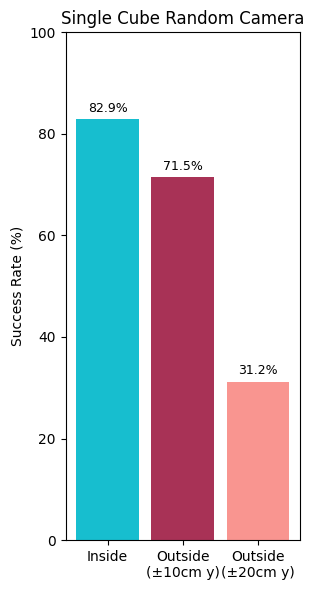

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

heights = [82.9, 71.5, 31.2]
# heights = [100.0, 88.1, 38.6]  # Success rates for inside, outside ±10cm, outside ±20cm
bar_labels = ["Inside", "Outside\n(±10cm y)", "Outside\n(±20cm y)"]
colors = ["tab:cyan", "#a83256", "#f99590"]

fig, ax = plt.subplots(figsize=(3.2, 6))

x_pos = np.array([0, 0.6, 1.2])  # barre vicinissime
width = 0.5  # barre strette

bars = ax.bar(x_pos, heights, color=colors, width=width)

ax.set_xticks(x_pos)  # etichette centrate sulle barre
xticklabels = ax.set_xticklabels(bar_labels)

# Centrare orizzontalmente le etichette x (anche quelle multilinea)
plt.setp(xticklabels, ha='center')

ax.set_ylim(0, 100)
ax.set_ylabel("Success Rate (%)")
ax.set_title("Single Cube Random Camera")
# ax.set_title("Multi Cube Random Camera")

for bar in bars:
    h = bar.get_height()
    ax.annotate(f"{h:.1f}%",
                xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 3), textcoords="offset points",
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()




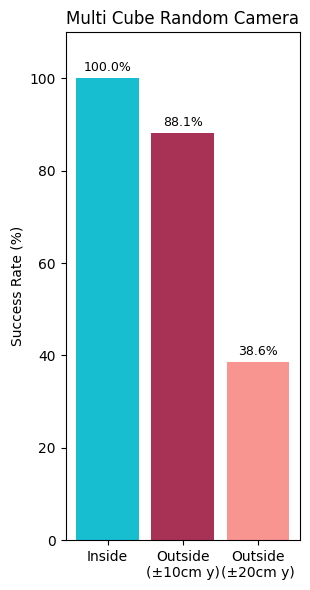

In [5]:
import matplotlib.pyplot as plt
import numpy as np

#heights = [82.9, 71.5, 31.2]
heights = [100.0, 88.1, 38.6]  # Success rates for inside, outside ±10cm, outside ±20cm
bar_labels = ["Inside", "Outside\n(±10cm y)", "Outside\n(±20cm y)"]
colors = ["tab:cyan", "#a83256", "#f99590"]

fig, ax = plt.subplots(figsize=(3.2, 6))

x_pos = np.array([0, 0.6, 1.2])  # barre vicinissime
width = 0.5  # barre strette

bars = ax.bar(x_pos, heights, color=colors, width=width)

ax.set_xticks(x_pos)  # etichette centrate sulle barre
xticklabels = ax.set_xticklabels(bar_labels)

# Centrare orizzontalmente le etichette x (anche quelle multilinea)
plt.setp(xticklabels, ha='center')

ax.set_ylim(0, 110)
ax.set_ylabel("Success Rate (%)")
ax.set_title("Multi Cube Random Camera")
# ax.set_title("Multi Cube Random Camera")

for bar in bars:
    h = bar.get_height()
    ax.annotate(f"{h:.1f}%",
                xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 3), textcoords="offset points",
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Graph to show tendency when changing dataset size

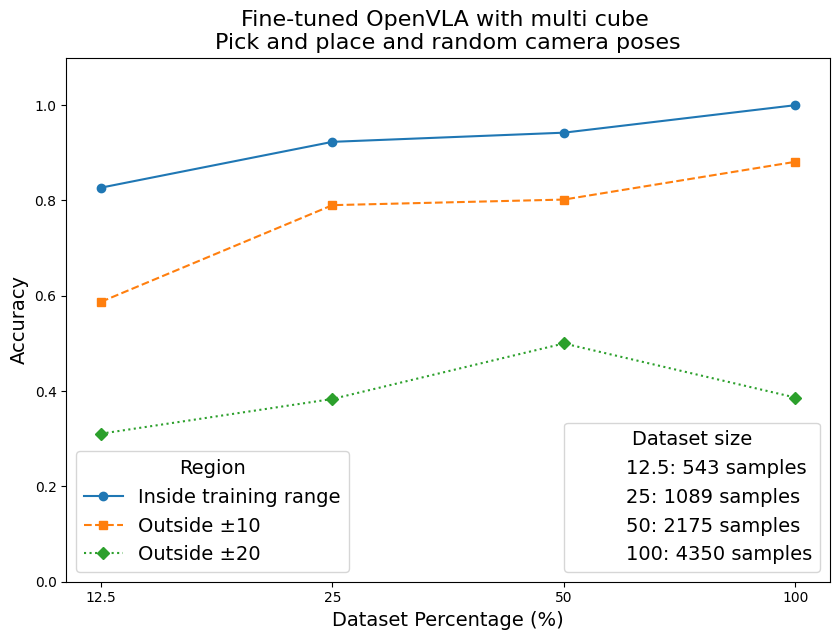

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.lines import Line2D

# === Helpers ===
def load_jsonl(path, skip_first=True):
    recs = []
    with open(path, 'r') as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        if skip_first and i == 0:
            continue
        line = line.strip()
        if not line:
            continue
        try:
            recs.append(json.loads(line))
        except json.JSONDecodeError:
            continue
    return recs

# === File‐naming template for each split directory ===
files = {
    'in':   '/multi_s_cub_r_tar_r_cam_camerainrange.json',
    '-10':  '/multi_s_cub_r_tar_r_cam_rangeyout_-10.json',
    '+10':  '/multi_s_cub_r_tar_r_cam_rangeyout_+10.json',
    '-20':  '/multi_s_cub_r_tar_r_cam_rangeyout_-20.json',
    '+20':  '/multi_s_cub_r_tar_r_cam_rangeyout_+20.json',
}

# === Percentage splits (folder suffix vs. tick label) ===
splits = [
    ("12+5", "12.5"),
    ("25",   "25"),
    ("50",   "50"),
    ("100",  "100")
]

# Known sample counts per split
sample_counts = {
    "12.5": 543,
    "25":   1089,
    "50":   2175,
    "100":  4350
}

# === Collect accuracy lists ===
labels         = []
acc_in_list    = []
acc_out10_list = []
acc_out20_list = []

for folder_suffix, tick_label in splits:
    base_dir = f'isaac_ws/src/stats/multi_s_cub_r_tar_r_cam_{folder_suffix}%'
    
    rec_in = load_jsonl(base_dir + files['in'], skip_first=True)
    rec_out10 = (load_jsonl(base_dir + files['-10'], skip_first=True) +
                 load_jsonl(base_dir + files['+10'], skip_first=True))
    rec_out20 = (load_jsonl(base_dir + files['-20'], skip_first=True) +
                 load_jsonl(base_dir + files['+20'], skip_first=True))
    
    acc_in    = sum(r.get("completed", False) for r in rec_in)    / max(1, len(rec_in))
    acc_out10 = sum(r.get("completed", False) for r in rec_out10) / max(1, len(rec_out10))
    acc_out20 = sum(r.get("completed", False) for r in rec_out20) / max(1, len(rec_out20))
    
    labels.append(tick_label)
    acc_in_list.append(acc_in)
    acc_out10_list.append(acc_out10)
    acc_out20_list.append(acc_out20)

# === Plot ===
fig, ax = plt.subplots(figsize=(8.5,6.5))

# Three lines
line1, = ax.plot(labels, acc_in_list,    marker='o', linestyle='-', label='Inside training range')
line2, = ax.plot(labels, acc_out10_list, marker='s', linestyle='--', label='Outside ±10')
line3, = ax.plot(labels, acc_out20_list, marker='D', linestyle=':', label='Outside ±20')

ax.set_xlabel("Dataset Percentage (%)", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_title("Fine-tuned OpenVLA with multi cube \nPick and place and random camera poses", fontsize=16)
ax.set_ylim(0, 1.1)
ax.set_xticks(labels)

# Main legend for the three lines, aumentiamo fontsize del titolo e delle etichette
leg1 = ax.legend(loc='lower left', title="Region", fontsize=14, title_fontsize=14)

# Secondary legend for sample counts, idem
sample_handles = [
    Line2D([0], [0], color='none', label=f"{lab}: {sample_counts[lab]} samples")
    for lab in labels
]
leg2 = ax.legend(handles=sample_handles,
                 loc='lower right',
                 title="Dataset size",
                 fontsize=14,
                 title_fontsize=14)

ax.add_artist(leg1)

plt.tight_layout()
plt.show()

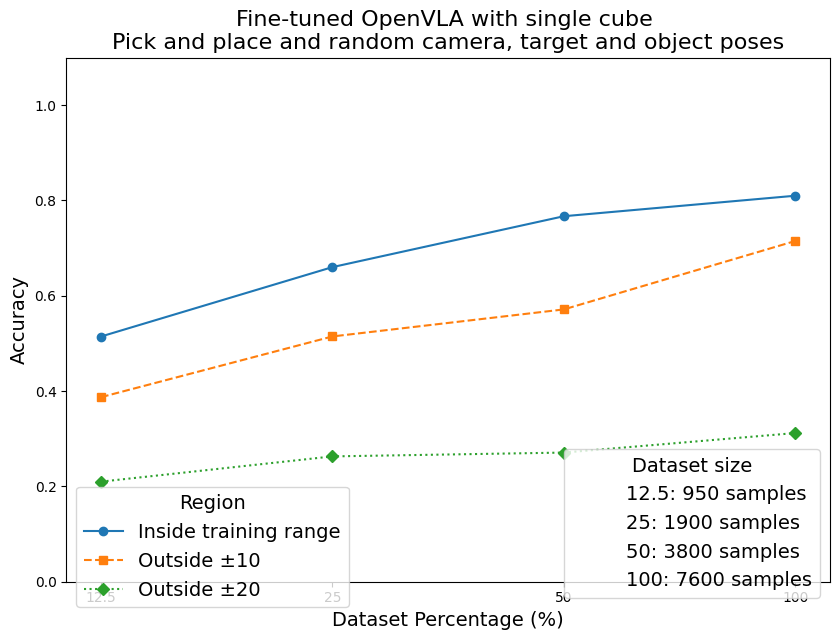

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.lines import Line2D

# === Helpers ===
def load_jsonl(path, skip_first=True):
    """Load JSONL file, optionally skipping the first line."""
    records = []
    with open(path, 'r') as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        if skip_first and i == 0:
            continue
        line = line.strip()
        if not line:
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue
    return records

# === File‐naming template for each split directory (single_green_r_all) ===
files = {
    'in':   '/single_green_r_all_camerainrange.json',
    '-10':  '/single_green_r_all_rangeyout_-10.json',
    '+10':  '/single_green_r_all_rangeyout_+10.json',
}

# === Percentage splits (folder suffix vs. tick label) ===
splits = [
    ("12+5", "12.5"),
    ("25",   "25"),
    ("50",   "50"),
    ("100",  "100")
]

# Known sample counts per split
sample_counts = {
    "12.5": 950,
    "25":   1900,
    "50":   3800,
    "100":  7600
}

# === Collect accuracy lists ===
labels        = []
acc_in_list   = []
acc_out10_list = []

for folder_suffix, tick_label in splits:
    base_dir = f'isaac_ws/src/stats/single_green_r_all_{folder_suffix}%'
    
    # Load in-range and ±10-range records
    rec_in = load_jsonl(base_dir + files['in'],  skip_first=True)
    rec_out10 = (load_jsonl(base_dir + files['-10'], skip_first=True) +
                 load_jsonl(base_dir + files['+10'], skip_first=True))
    
    # Compute accuracies
    acc_in   = sum(r.get("completed", False) for r in rec_in)   / max(1, len(rec_in))
    acc_out10 = sum(r.get("completed", False) for r in rec_out10) / max(1, len(rec_out10))
    
    labels.append(tick_label)
    acc_in_list.append(acc_in)
    acc_out10_list.append(acc_out10)

# === Plot ===
fig, ax = plt.subplots(figsize=(8.5, 6.5))

acc_out20_list = [0.21, 0.263, 0.271, 0.312]  # Placeholder for consistency

line_in   = ax.plot(labels, acc_in_list,    marker='o', linestyle='-', label='Inside training range')[0]
line_out  = ax.plot(labels, acc_out10_list, marker='s', linestyle='--', label='Outside ±10')[0]
line_out2 = ax.plot(labels, acc_out20_list, marker='D', linestyle=':', label='Outside ±20')[0]  # Placeholder for consistency

ax.set_xlabel("Dataset Percentage (%)", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_title("Fine-tuned OpenVLA with single cube \nPick and place and random camera, target and object poses", fontsize=16)
ax.set_ylim(0, 1.1)
ax.set_xticks(labels)

leg1 = ax.legend(handles=[line_in, line_out, line_out2], loc='upper left',
                 bbox_to_anchor=(0, 0.2), title="Region", fontsize=14, title_fontsize=14)

# Legend: Sample counts
sample_handles = [
    Line2D([0], [0], color='none', label=f"{lab}: {sample_counts[lab]} samples")
    for lab in labels
]
leg2 = ax.legend(handles=sample_handles, loc='lower right', title="Dataset size",
                 bbox_to_anchor=(1.0, -0.05), fontsize=14, title_fontsize=14)

# Add back the first legend
ax.add_artist(leg1)

plt.tight_layout()
plt.show()
